In [1]:
import pyfits 
import numpy as np 

In [3]:
photons = pyfits.open('/data/wavelets/fermi_output/photons_merged_cut_P8R2_PSF3_CLEAN_wavelets.fits')

In [4]:
photons.info()

Filename: /data/wavelets/fermi_output/photons_merged_cut_P8R2_PSF3_CLEAN_wavelets.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      31   ()              
1    EVENTS      BinTableHDU    221   9641340R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
2    GTI         BinTableHDU     46   45346R x 2C   [D, D]   


In [5]:
idx = np.where( (np.abs(photons[1].data['B'])<40) & (np.abs(photons[1].data['L'])<40) )[0]

In [6]:
lats = photons[1].data['B']
lons = photons[1].data['L']
E = photons[1].data['Energy']
print np.min(E), np.max(E)

500.0 99981.9


In [37]:
def BinPhotonsCartesian(phfile, l_max, b_max, resolution, E_range): 
    '''Return a binned cartesian count map symmetric in lat/lon about the GC. 
    
    Inputs: 
        phfile: filepath to f1 photon file output by Fermi tools.
        l_max: maximal Galactic longitude in degrees
        b_max: maximal Galactic latitude in degrees
        resolution: angular resolution in degrees for each pixel
        E_range: Energy high/low edge in GeV
    '''
    photons = pyfits.open(phfile)
    
    lons = photons[1].data['L']
    lons[lons>180] -= 360 # convert from 0-360 to -180-180
    E = photons[1].data['Energy']
    
    MET = photons[1].data['TIME']
    print 'Min/Max Mission Elapsed Time of Events', np.min(MET), np.max(MET)
    
    # Find photons in the window
    idx = np.where( (np.abs(photons[1].data['B'])<b_max) 
                   & (np.abs(photons[1].data['L'])<l_max) 
                   & (((E/1e3)>=E_range[0]) & ((E/1e3)<E_range[1])))[0]
    
    lats = photons[1].data['B'][idx]
    lons = lons[idx]
    lons[lons>180] -= 360 # convert from 0-360 to -180-180
    
    # init bins 
    l_bins = np.linspace(-l_max, l_max, int(2*l_max/resolution)+1)
    b_bins = np.linspace(-b_max, b_max, int(2*b_max/resolution)+1)
    
    h, l_bins, b_bins = np.histogram2d(lats,lons, (l_bins, b_bins) )
    
    return h, l_bins, b_bins
    
    
  

In [38]:

phfile = '/data/wavelets/fermi_output/photons_merged_cut_P8R2_PSF3_CLEAN_wavelets.fits'
resolution = 0.1 # pixel dimensions in GeV
l_max, b_max = 20, 20 
E_bins = np.logspace(np.log10(.5), 2, 7) #Energy bin edges in GeV


binned_photons = []
l_bins=None
b_bins=None
for i_E in range(len(E_bins)-1):
    E_low, E_high = E_bins[i_E], E_bins[i_E+1]
    
    h, l_bins, b_bins = BinPhotonsCartesian(phfile, l_max, b_max, resolution, (E_low, E_high))
    binned_photons.append(h)


np.save('../output/cartesian_count_map_0.1deg.npy', np.array(binned_photons))

Min/Max Mission Elapsed Time of Events 239557447.812 457046600.227
Min/Max Mission Elapsed Time of Events 239557447.812 457046600.227
Min/Max Mission Elapsed Time of Events 239557447.812 457046600.227
Min/Max Mission Elapsed Time of Events 239557447.812 457046600.227
Min/Max Mission Elapsed Time of Events 239557447.812 457046600.227
Min/Max Mission Elapsed Time of Events 239557447.812 457046600.227


In [40]:
np.save('../output/E_bins.npy', np.array(E_bins))
np.save('../output/l_bins_0.1deg.npy', np.array(l_bins))
np.save('../output/b_bins_0.1deg.npy', np.array(b_bins))

-c:5: RuntimeWarning: divide by zero encountered in log10


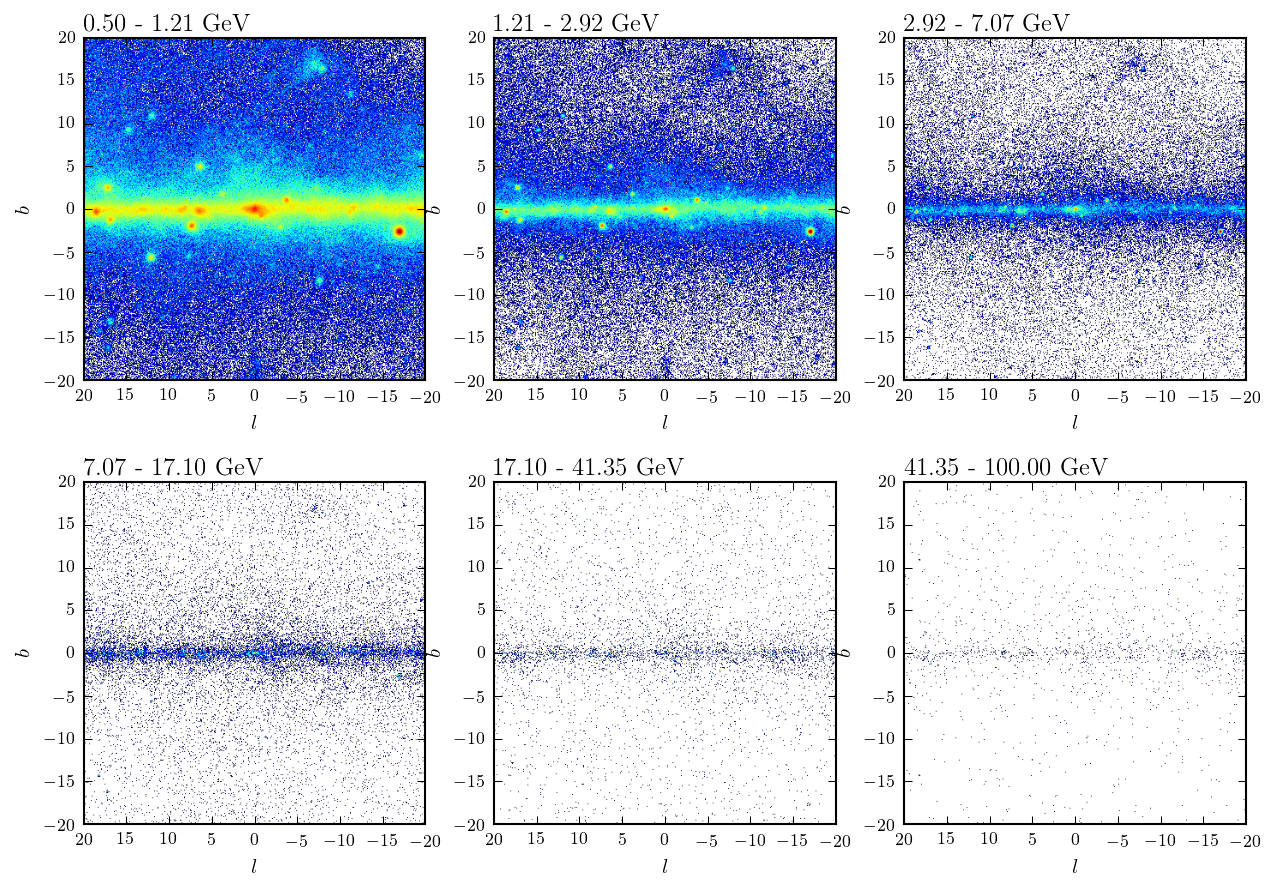

In [41]:
plt.figure(figsize=(10,7))

for i_E, photons in enumerate(binned_photons):
    plt.subplot(2,3,i_E+1)
    plt.imshow(np.log10(photons), origin='lower', extent=[-l_max, l_max, -b_max, b_max])
    plt.xlim(20,-20)
    plt.ylabel('$b$')
    plt.xlabel('$l$')
    #central_energy = np.exp(.5(*np.log(E_bins[i_E])+np.log(E_bins[i_E+1]))
    plt.text(0, 1.02, r' %1.2f - %1.2f GeV'%(E_bins[i_E],E_bins[i_E+1]) ,transform=plt.gca().transAxes, color='k')
    #plt.show()